In [1]:
### Defining Environment variables pointing to user folders
from os import environ, path, makedirs
from json import load

environ.setdefault('HOME_DIR', "/mlinfn/shared/lamarr/"+ environ['USERNAME'])
environ.setdefault('TRAINING_DATA_FOLDER',"/j100")
environ.setdefault('MODEL_STORAGE'  ,environ['HOME_DIR']+"/trained_models"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault('FEATHER_FOLDER' ,environ['HOME_DIR']+"/lb-trksim-train/notebooks/feather_folder"+environ['TRAINING_DATA_FOLDER'])
environ.setdefault("TRAIN_DATA"     ,environ['FEATHER_FOLDER']+"/efficiency-train")
environ.setdefault("VALIDATION_DATA",environ['FEATHER_FOLDER']+"/efficiency-validation")

environ.setdefault("MODEL_VARIANT","")
default_output_model = "/models/efficiency/saved_model.pb"
if environ['MODEL_VARIANT'] != '':
    model_path,model_name = path.split(default_output_model)
    default_output_model = path.join(model_path,environ['MODEL_VARIANT'], model_name)
environ.setdefault('OUTPUT_MODEL',environ['MODEL_STORAGE']+default_output_model)

with open("Models_definitions.json") as mdl_file: # definition of variant models
    models_def = load(mdl_file)
    environ.setdefault('MODEL_DEFINITION',models_def['efficiency'].get(environ['MODEL_VARIANT'],"EfficiencyNN(layers=5,X_shape=X.shape,y_shape=y.shape)"))

_ = environ.setdefault('NB_EXPORT',"True") # whether export notebooks

In [2]:
%run construct_models.py # script containing models definitions

# Training of the efficiency model
##### Notebook tested within the environment `TensorFlow on GPU` available in the docker image [`landerlini/lhcbaf:v0p8`](https://hub.docker.com/r/landerlini/lhcbaf)

This notebook is part of a pipeline, in particular it requires the data preprocessed as defined in the notebook [Preprocessing.ipynb](./Preprocessing.ipynb) and the validation of the trained model is demanded to the notebook [Efficiency-validation.ipynb](./Efficiency-validation.ipynb).

Here, we define the training procedure for the Deep Neural Network model defining the class each track is reconstructed as.
As evident from the preprocessing step, we restrain the classes to:
 * long tracks (traversing the whole detector)
 * upstream tracks (traversing the VELO and the Tracker Turincensis)
 * downstream tracks (traversing the Tracker Turicensis and the downstream tracker, TT).
 
We include as a class the "unreconstructed" category which includes both the non-reconstructed particles and those reconstructed as other classes.
 
The neural network we will train is designed to predict the probability each track is reconstructed as a given track.
In the deployment of the model we will assign the particle to a single class, by drawing one of the classes above based on the probabilities obtained from the network.

The classes are mutually exclusive, each particle can be assigned to at most one of the reconstruction classes.
Hence, we describe the problem as a multiclass classification with a multinomial probability function and a Categorical Cross-entropy as loss function.

## Libraries and environment setup

As for the [training of the acceptance model](./Acceptance.ipynb), we are using here the standard software stack for TensorFlow on GPU.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
from os import environ

## Remove annoying warnings 
environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

We ensure the GPU is properly loaded and assigned to TensorFlow as hardware accelerator for the training.

If the GPU is loaded properly, the following code block should result in a string similar to `'/devince:GPU:0'`.

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

## Loading data 

We are reading the data using our custom implementation of `FeatherReader` streaming the data directly to TensorFlow.
In particular, we are loading:
 * the training dataset to optimize the weights;
 * the validation dataset to evaluate possible overtraining and select model and tune the regularization hyper-parameters and techniques.

In [5]:
from feather_io import FeatherReader

data_reader_train =  FeatherReader(environ.get("TRAIN_DATA", "efficiency-train"))
train_dataset = data_reader_train.as_tf_dataset()
data_reader_validation =  FeatherReader(environ.get("VALIDATION_DATA", "efficiency-validation"))
validation_dataset = data_reader_validation.as_tf_dataset()

/envs/root/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We also load to RAM a small chunk of data to ease the model building.

In [6]:
X, y = next(iter(train_dataset.batch(1_000_000)))
y.shape

TensorShape([1000000, 4])

## Model definition

We define the neural network as a deep network with skip connections to limit the gradient vanishing problem.

Note that the activation of the last layer is a [softmax](https://keras.io/api/layers/activations/#softmax-function) as expected by the [Categorical Cross-entropy loss function](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class).

Unfortunately, the `scikinC` package that we are relying on to deploy these models in Lamarr does not support the `softmax` activation function is indicated as a string, but needs it defined as an independent layer.

In [7]:
model = eval(environ["MODEL_DEFINITION"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          1664        ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 add (Add)                      (None, 128)          0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

The configuration of the training is standard for the multiclass classification task.

 * [`CategoricalCrossentropy`](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) loss function
 * [`RMSprop`](https://keras.io/api/optimizers/rmsprop/) optimizer

In [8]:
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import RootMeanSquaredError

Once again we split the training procedure in two steps, we train with a very high learning rate as long as it brings to some improvement in the value of the loss function. Then we drastically reduce it to a much smaller value.

Note that to limit the local minima in the loss function and ease convergence towards the global minimum at such a high learning rate, we apply a small [smoothing of the labels](https://towardsdatascience.com/what-is-label-smoothing-108debd7ef06). 
This results into a non-probabilistic meaning of the generated output, which is unaccepable to our purpose.
Hence, we reset the label smoothing to zero for the second (and last) part of the training with a reduced learning rate.



In [9]:
from models_utils import CustomCallback,plot_weight_distributions #plot weights distributions during training

Epoch 1/50
26/26 [==============================] - 9s 280ms/step - loss: 2.7831 - root_mean_squared_error: 0.2874 - val_loss: 1.7009 - val_root_mean_squared_error: 0.1847
Epoch 2/50
26/26 [==============================] - 8s 284ms/step - loss: 1.5677 - root_mean_squared_error: 0.2088 - val_loss: 1.3941 - val_root_mean_squared_error: 0.2225
Epoch 3/50
26/26 [==============================] - 7s 261ms/step - loss: 1.1592 - root_mean_squared_error: 0.2133 - val_loss: 0.8684 - val_root_mean_squared_error: 0.1926
Epoch 4/50
26/26 [==============================] - 7s 268ms/step - loss: 0.9611 - root_mean_squared_error: 0.2283 - val_loss: 0.6674 - val_root_mean_squared_error: 0.1725
Epoch 5/50
26/26 [==============================] - 7s 276ms/step - loss: 0.6504 - root_mean_squared_error: 0.1970 - val_loss: 1.8279 - val_root_mean_squared_error: 0.3484
Epoch 6/50
26/26 [==============================] - 7s 248ms/step - loss: 0.7227 - root_mean_squared_error: 0.2135 - val_loss: 0.5344 - val_

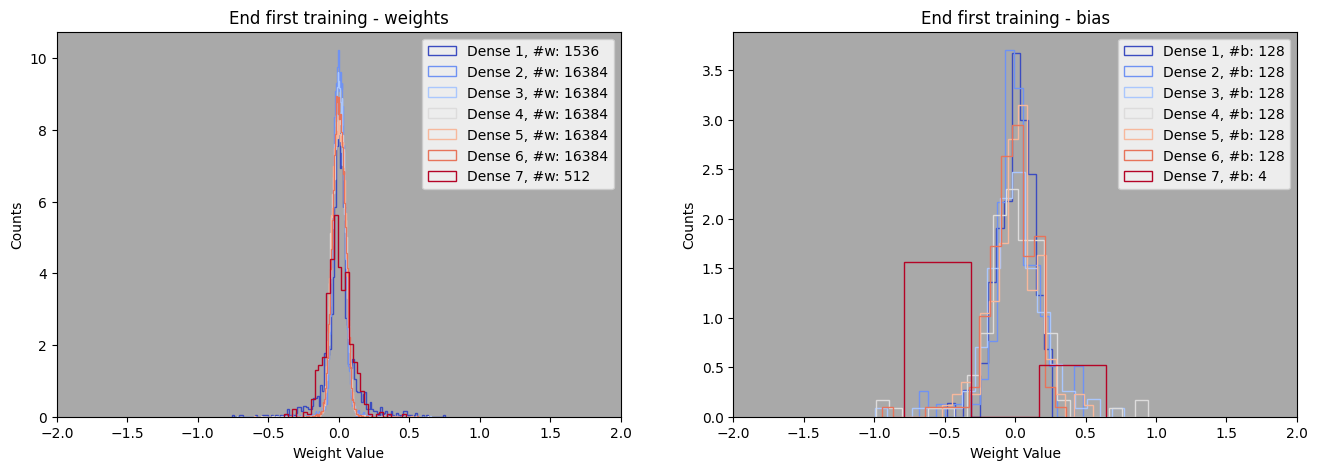

In [10]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.01), optimizer=RMSprop(10e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

batch_size=100_000

training_data = train_dataset.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
validation_data=next(iter(validation_dataset.batch(batch_size)))

history = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])
plot_weight_distributions(model,title="End first training")

Epoch 1/50
26/26 [==============================] - 7s 260ms/step - loss: 0.3437 - root_mean_squared_error: 0.1631 - val_loss: 0.3046 - val_root_mean_squared_error: 0.1614
Epoch 2/50
26/26 [==============================] - 7s 247ms/step - loss: 0.2864 - root_mean_squared_error: 0.1594 - val_loss: 0.2705 - val_root_mean_squared_error: 0.1583
Epoch 3/50
26/26 [==============================] - 7s 245ms/step - loss: 0.2636 - root_mean_squared_error: 0.1585 - val_loss: 0.2572 - val_root_mean_squared_error: 0.1593
Epoch 4/50
26/26 [==============================] - 8s 304ms/step - loss: 0.2513 - root_mean_squared_error: 0.1579 - val_loss: 0.2473 - val_root_mean_squared_error: 0.1582
Epoch 5/50
26/26 [==============================] - 7s 252ms/step - loss: 0.2440 - root_mean_squared_error: 0.1577 - val_loss: 0.2437 - val_root_mean_squared_error: 0.1586
Epoch 6/50
26/26 [==============================] - 7s 245ms/step - loss: 0.2381 - root_mean_squared_error: 0.1572 - val_loss: 0.2350 - val_

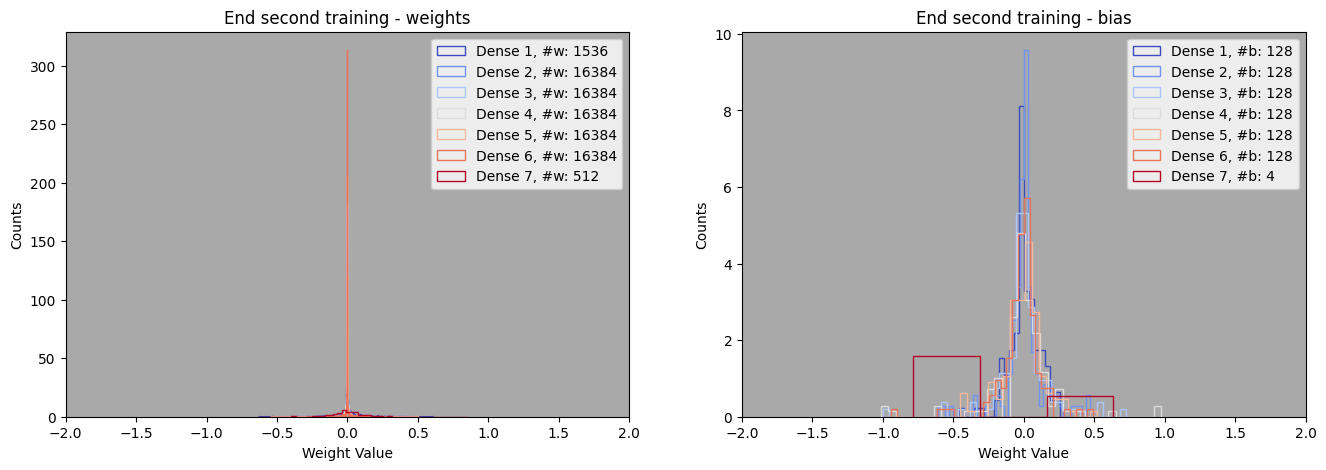

In [11]:
model.compile(loss=CategoricalCrossentropy(label_smoothing=0.00), optimizer=RMSprop(1e-3), metrics=[RootMeanSquaredError()])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history_ft = model.fit(training_data, epochs=50, validation_data=validation_data, callbacks=[early_stopping])
plot_weight_distributions(model,title="End second training")

The two training phases are well visible in the plot below reporting the full history of the training procedure.

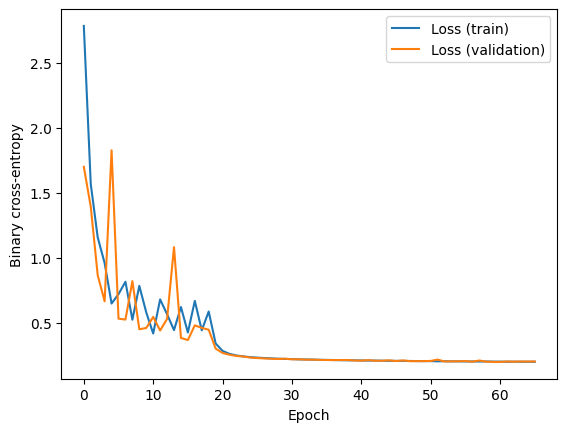

In [12]:
plt.plot(history.history['loss'] + history_ft.history['loss'], label="Loss (train)")
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label="Loss (validation)")
plt.xlabel("Epoch")
plt.ylabel("Binary cross-entropy")
plt.yscale('linear')
plt.legend()
plt.show()

## A first rough validation (sanity checks)

As done for the [acceptance training](./Acceptance.ipynb), we perform simple and quick checks on the trained model to ensure that the model makes sense, while demanding the most important part of the validation to a [dedicated notebook](./Efficiency-validation.ipynb).

First we plot the distribution of the original labels and of the predictions for the various categories. 

1/1 [==============================] - 0s 110ms/step
1.0000113158440678


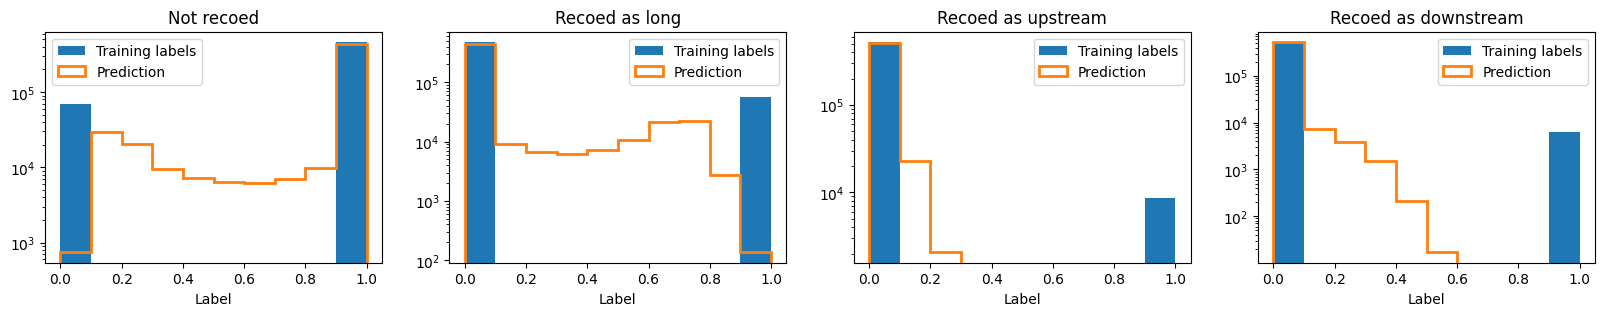

In [13]:
head = data_reader_validation.as_dask_dataframe().head(1_000_000, npartitions=-1)
Xv = head[data_reader_validation.features].values
yv = head[data_reader_validation.labels].values
yv_hat = model.predict(Xv, batch_size=len(Xv))

print (yv.sum(axis=1).mean(axis=0))

n_classes = len(data_reader_validation.labels)
plt.figure(figsize=(5*n_classes, 3))

for iVar, varname in enumerate(data_reader_validation.labels, 0):
    plt.subplot(1, n_classes, iVar+1)
    
    bins = np.linspace(0, 1, 11)
    plt.hist(yv[:, iVar], bins=bins, label="Training labels")
    plt.hist(yv_hat[:, iVar], bins=bins, histtype='step', linewidth=2, label="Prediction")
    plt.title(varname.replace("_", " ").capitalize())
    plt.xlabel("Label")
    plt.legend()
    plt.yscale('log')
plt.show()

Then we use the probability of belonging to the `long track` class as a weight to compare the distribution of candidates reconstructed as long tracks in the detailed simulation with candidates probably reconstructable as `long tracks` according to Lamarr.

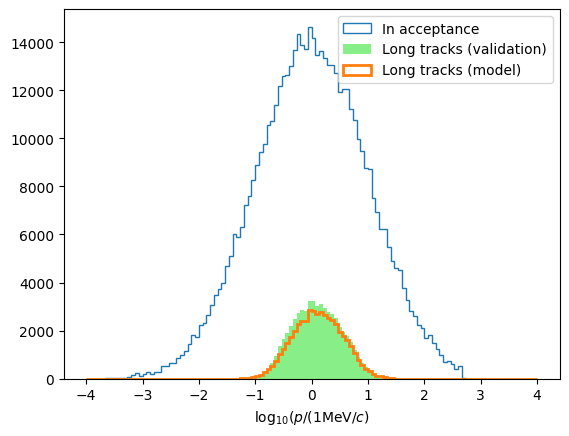

In [14]:
log_p = head['mc_log10_p']
mask_long = head['recoed_as_long'] == 1
w_long = yv_hat[:, data_reader_validation.labels.index('recoed_as_long')]

bins = np.linspace(-4, 4, 121)
denominator, _ = np.histogram(log_p, bins=bins)
true_numerator, _ = np.histogram(log_p[mask_long], bins=bins)
predicted_numerator, _ = np.histogram(log_p, bins=bins, weights=w_long)

plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=denominator, label="In acceptance", histtype='step')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=true_numerator, label="Long tracks (validation)", color='#8e8')
plt.hist((bins[1:] + bins[:-1])/2, bins=bins, weights=predicted_numerator, label="Long tracks (model)", histtype='step', linewidth=2)

plt.xlabel(r"$\log_{10} \left(p / (1 \mathrm{MeV}/c\right)$")
plt.legend()
plt.show()

# Exporting the model

As a last step, we export the model to the same directory where we stored the preprocessing steps.

In [15]:
from models_utils import GetModelProperties,MakeMD
from json import dump

base_dir = path.dirname(environ['OUTPUT_MODEL'])
makedirs(base_dir,exist_ok=True)
model.save(base_dir)

# save model and training information
jsonfile = "model_info.json"
info_path = path.join(base_dir, jsonfile)
props = GetModelProperties(model,history=history_ft)

with open(path.join(base_dir, jsonfile),'w') as json_file:
    dump(props,json_file)

# write model description in MD file
MakeMD(props,mdfile=path.join(base_dir, "model_info.md"))

INFO:tensorflow:Assets written to: /mlinfn/shared/lamarr/scapelli/trained_models/j100/models/efficiency/assets


# Conclusion

In this notebook we trained a model for the track reconstruction efficiency, implemented a very simple sanity check to ensure that the trained model makes sense, and finally we exported it to perform a more complete validation in a dedicated notebook.


In [16]:
### export notebooks for comparisons
if environ.get('NB_EXPORT',"False")=="True":
    from os import system,makedirs
    
    nb_save  = f"{environ['HOME_DIR']}/notebooks_exports" # export output dir
    nb_save  = nb_save+environ['TRAINING_DATA_FOLDER']    # according to train data
    if environ['MODEL_VARIANT'] != '':
        nb_save  = nb_save+'/'+environ['MODEL_VARIANT']   # according to model variant
    makedirs(nb_save,exist_ok=True)                       # create if not exists
    
    nbs_path = f"{environ['HOME_DIR']}/lb-trksim-train/notebooks" # notebooks folder
    nb_filename = "Efficiency.ipynb"                              # notebook name
    extensions  = ["html"]                                  # export formats
    for ext in extensions:
        system("jupyter nbconvert --log-level=40 --no-input --output-dir {0} --to {1} {2}/{3}".format(nb_save,ext.upper(),nbs_path,nb_filename))
    print("Exported {} as {} in {}".format(nb_filename,','.join(extensions),nb_save))

Exported Efficiency.ipynb as html,pdf in /mlinfn/shared/lamarr/scapelli/notebooks_exports/j100


[NbConvertApp] CRITICAL | xelatex failed: ['xelatex', 'notebook.tex', '-quiet']
b"This is XeTeX, Version 3.14159265-2.6-0.999991 (TeX Live 2019/Debian) (preloaded format=xelatex)\n restricted \\write18 enabled.\nentering extended mode\n(./notebook.tex\nLaTeX2e <2020-02-02> patch level 2\nL3 programming layer <2020-02-14>\n(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls\nDocument Class: article 2019/12/20 v1.4l Standard LaTeX document class\n(/usr/share/texlive/texmf-dist/tex/latex/base/size11.clo))\n(/usr/share/texlive/texmf-dist/tex/latex/tcolorbox/tcolorbox.sty\n(/usr/share/texlive/texmf-dist/tex/latex/pgf/basiclayer/pgf.sty\n(/usr/share/texlive/texmf-dist/tex/latex/pgf/utilities/pgfrcs.sty\n(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common.tex\n(/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-common-lists.t\nex)) (/usr/share/texlive/texmf-dist/tex/generic/pgf/utilities/pgfutil-latex.def\n(/usr/share/texlive/texmf-dist/tex/latex/ms/ever